                                    Рекомендательная система для фильмов
                    Выполнили студенты АСОИ-181: Дроздов И.В., Ситников С.В., Матиевский В.А.
                    
Метод коллаборативной фильтрации в рекомендательных системах предсказывает оценку или предпочтение, которое пользователь будет отдавать объекту на основе его прежних оценок или предпочтений. Системы рекомендаций используются практически каждой крупной компанией для повышения качества предложения своих услуг.

Для создания нашей системы мы будем использовать Python и библиотеку для глубокого обучения fast.ai, инструмент для интерактивной разработки Jupyter Notebook. Датасет с фильмами взят с сайта kaggle: https://www.kaggle.com/rounakbanik/the-movies-dataset?select=ratings.csv, он содержит несколько тысяч различных фильмов и более 100 000 оценок. Он имеет три характеристики: movie_id, user_id и рейтинг.

Приступим...

После загрузки датасета нам нужно загрузить модуль коллаборативной фильтрации FastAI, указать путь к датасету и загрузить CSV, содержащий рейтинги.

In [103]:
from fastai import * 
from fastai.collab import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [106]:
data = pd.read_csv("./ratings_small.csv")

In [ ]:
Построим гистограмму рейтинга, чтобы оценить нашу выборку

/home/ignat/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


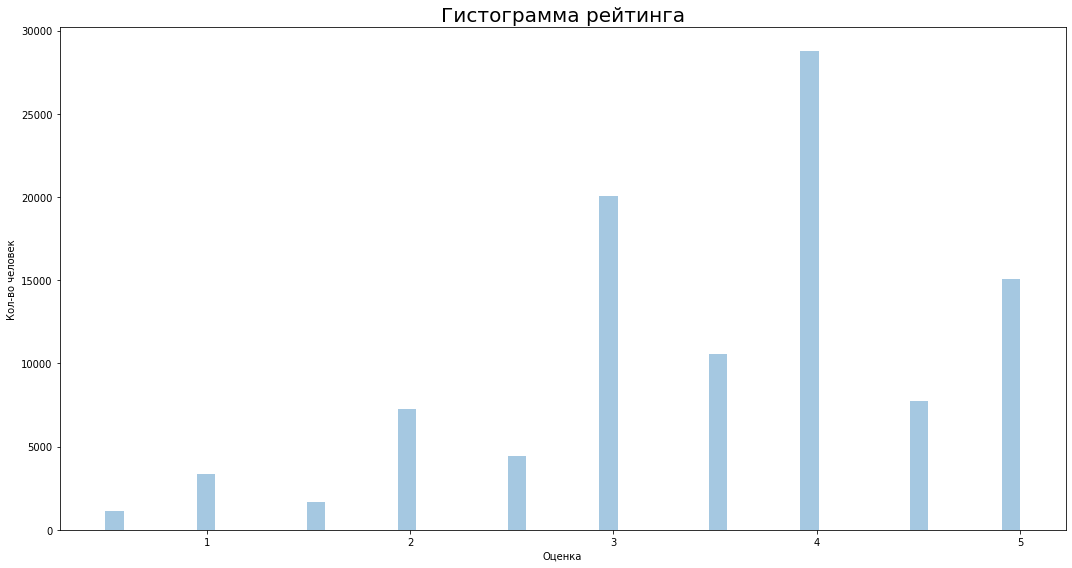

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.distplot(data.rating, ax = ax, kde = False)
ax.set_title("Гистограмма рейтинга", fontsize = 20)
ax.set_xlabel('Оценка')
ax.set_ylabel('Кол-во человек')
plt.tight_layout()
plt.show()

FastAI поддерживает два разных типа моделей коллаборативной фильтрации. Первая — простая модель под названием EmbeddingDotBias. По сути она создает векторные представления как для пользователей, так и для фильмов, а затем берет их скалярное произведение. Вторая — это модель на основе нейронной сети, которая использует векторные представления и полносвязные слои.

Векторное представление (embedding) — это перевод из дискретных объектов, таких как слова или идентификаторы фильмов и, в нашем случае, пользователей, в вектор вещественных значений. Это можно использовать для нахождения сходства между дискретными объектами, которое не было бы очевидным для модели, если бы в ней не использовались слои векторных представлений.

Эти векторные представления являются низкоразмерными и обновляются во время обучения сети.

Обе модели могут быть созданы с использованием класса collab_learner. По умолчанию аргумент use_nn имеет значение false, то есть мы создаем модель EmbeddingDotBias.

В качестве следующих аргументов мы можем передать в collab_learner аргумент n_factors, который представляет размер векторных представлений, а также аргумент y_range, который указывает диапазон значений рейтинга.

Мы попробовали оба вида фильтрации. Но в дальнейшем будем использовать более простую EmbeddingDotBias в силу небольшого размера выборки. Модель на основе нейронной сети также была создана и сохранена. 

Количесвто пользователей: 672
Количество фильмов: 8749
минимальный рейтинг = 0.5, максимальный рейтинг = 5.0


epoch,train_loss,valid_loss,time
0,1.266484,1.231015,00:12
1,0.813744,0.846229,00:12
2,0.711736,0.804244,00:12
3,0.664238,0.792594,00:11
4,0.654829,0.791059,00:11


Path('models/goodmovies-dot-model.pth')

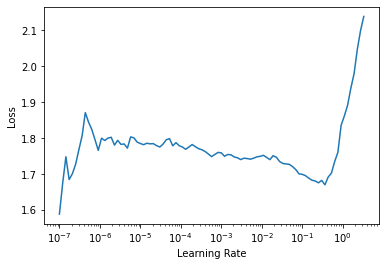

In [61]:
loaded_data= CollabDataLoaders.from_df(data, user_name = "userId", item_name = "movieId", rating_name = "rating", valid_pct = .1)
print(f"Количесвто пользователей: {len(loaded_data.classes['userId'])}")
print(f"Количество фильмов: {len(loaded_data.classes['movieId'])}")
min_rating = data.rating.min() 
max_rating = data.rating.max()
print(f"минимальный рейтинг = {min_rating}, максимальный рейтинг = {max_rating}")
learn_n = collab_learner(dls = loaded_data, n_factors = 60, y_range = (min_rating, max_rating))
learn_n.lr_find()
learn_n.fit_one_cycle(n_epoch = 5, lr_max = 1e-3, wd = 1e-2)
learn_n.save('goodmovies-dot-model')

Теперь мы можем найти learning rate, обучить нашу модель с помощью метода fit_one_cycle и сохранить модель для дальнейшего использования. Тоже самое делаем и для модели на основе нейронной сети ниже.

epoch,train_loss,valid_loss,time
0,0.856529,0.832251,00:30
1,0.789857,0.791004,00:37
2,0.708612,0.768529,00:34
3,0.642623,0.777170,00:35
4,0.544885,0.793670,00:59


Path('models/goodmovies-nn-model.pth')

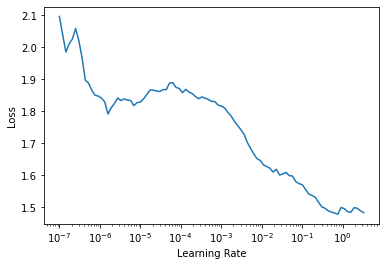

In [15]:
learn_nn = collab_learner(dls = loaded_data, use_nn = True, emb_szs = {"user_weights":60, "movie_weights": 60}, y_range = (min_rating, max_rating), layers = [120, 50])
learn_nn.lr_find()
learn_nn.fit_one_cycle(n_epoch = 5, lr_max = 1e-3, wd = 1e-2)
learn_nn.save('goodmovies-nn-model')

Как мы можем заметить модель на основе нейронной сети даёт лучший результат, однако требует в разы больше времени на обучение.

In [150]:
learn_n.model

EmbeddingDotBias(
  (u_weight): Embedding(672, 60)
  (i_weight): Embedding(8749, 60)
  (u_bias): Embedding(672, 1)
  (i_bias): Embedding(8749, 1)
)

Как видно выше у модели есть по 2 компонента для пользователя и фильма. Один из них - вектор, другой - "смещение" оценки. Произведём сортировку фильмов по рейтингу (только не по его значению, а по общему числу оцениваний).

In [152]:
g = data.groupby(by = ['movieId'])['rating'].count()
most_rated_movies = g.sort_values(ascending=False).index.values

In [ ]:
import torch
most_rated_movies = most_rated_movies.astype(int)
x = torch.tensor(most_rated_movies).to(torch.int64)
biases = learn_n.model.bias(x, is_item = True)

In [153]:
learn_n.load('goodmovies-dot-model');

Проверим "предвзятость" или "смещение" оценок. Как мы видим у фильмов с низким рейтингом это значение невелико. А соответсвтенно можно сделать вывод, что эти фильмы не нравятся основной массе зрителей, независимо от их предпочтений и наша модель достаточно достоверно отражает это.

In [162]:
bias_rating_data.sort_values(by = ["Ratings"], ascending = True).head()

,Name,Ratings,Biases
876,637,0.5,-0.011963
926,1037,0.5,-0.012391
590,252,1.0,0.015579
345,784,1.0,-0.042757
221,3052,1.0,0.019901


Далее мы визуализируем наши результаты. Веса - это и есть наши векторы. Выясним вес 100 лучших фильмов и сравним визуально на двумерном графике. Применим РСА - метод для уменьшения размерности, используемый для сжатия векторов.
ID самых популярных фильмов находятся выше и правее на графике...

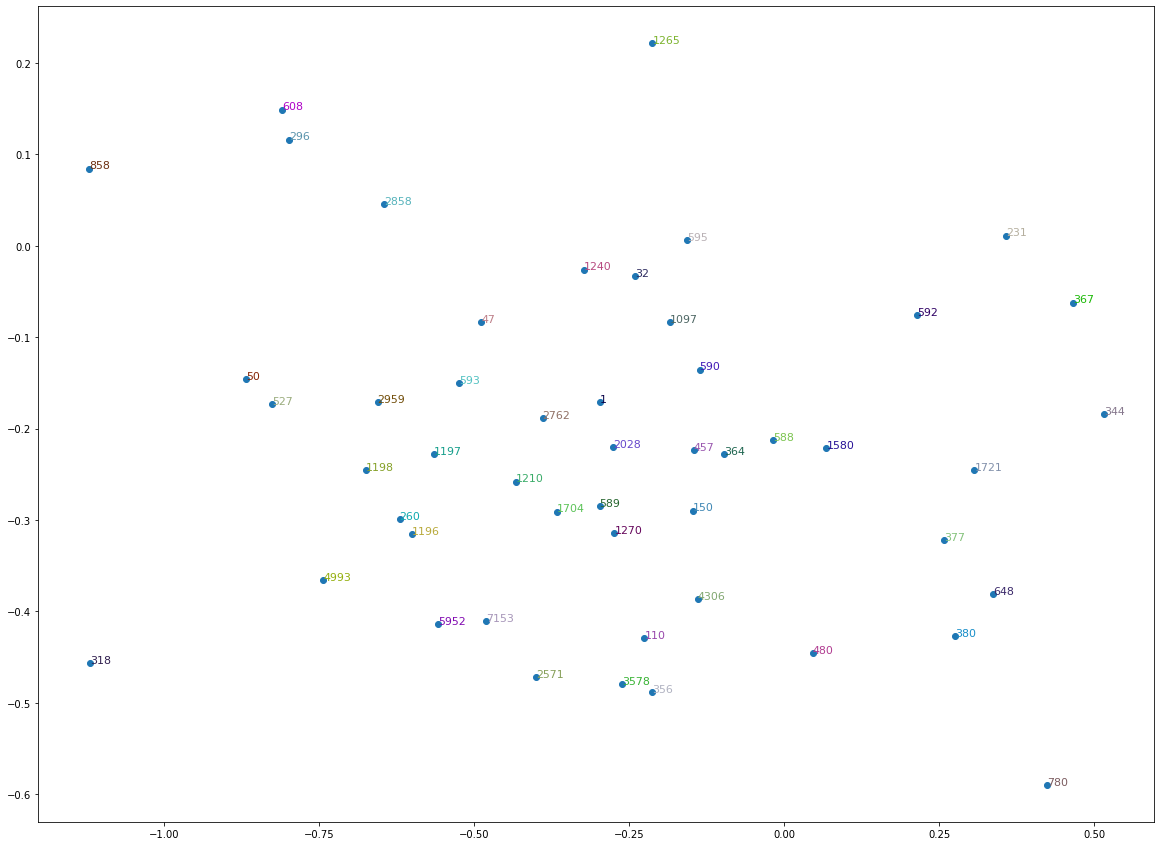

In [123]:
import numpy as np
most_rated_movies_weights = learn_n.model.weight(x, is_item = True)
most_rated_movies_weights_compressed = most_rated_movies_weights.pca(3).T

plot_n = 50
idxs = list(range(plot_n))

X = most_rated_movies_weights[0,:plot_n]
Y = most_rated_movies_weights[1,:plot_n]

plt.figure(figsize=(20,15))
plt.scatter(X, Y)
for i, x, y in zip(x[idxs], X, Y):
    plt.text(x, y, i, color = np.random.rand(3) * 0.8, fontsize=11)
plt.show()

В результате проделанной работы, мы получили готовую модель для дальнейшего использования при разработке веб-приложения.